In [1]:
%load_ext memory_profiler

In [2]:
import json

import numpy as np
import pandas as pd
# import geopandas as gpd
import rioxarray as riox

from pyproj import Transformer
from shapely.geometry import mapping, Point

## show the mean from scaled data and the scaled mean are the same

In [3]:
random_data = np.random.random(100) * 600 + 124
random_data[:5]

array([301.43694295, 643.05399645, 681.56602828, 634.15142661,
       188.58588869])

In [4]:
scaling = 5
offset = -3

In [5]:
(random_data * scaling + offset).mean()

2176.6615862275535

In [6]:
random_data.mean() * scaling + offset

2176.6615862275535

__No need to scale the data, but only set the missing value to 0__

## Run the analysis in a scalable way

load the raster and fill NaNs with 0

In [7]:
myraster = (
    riox.open_rasterio('test-data/Impervious_Surface_NOAA_Satellite_2010/Impervious_Surface_NOAA_Satellite_2010/data_provided/impsa_2010_20210519.tif')
    .sel(band=1)
)

In [8]:
myraster = myraster.where(myraster != myraster.rio.nodata, 0)

Load points for data extraction and create buffers

In [9]:
transformer = Transformer.from_crs("EPSG:3577", myraster.rio.crs, always_xy=True)

In [10]:
points = (
    pd.read_csv('test-data/APPMA_test_subset.csv')
    .assign(
        lat_lon_tuple = lambda columns: columns[['x', 'y']].apply(lambda row: transformer.transform(row['x'], row['y']), axis=1),
        lat = lambda columns: columns['lat_lon_tuple'].apply(lambda el: el[0]),
        lon = lambda columns: columns['lat_lon_tuple'].apply(lambda el: el[1]),
        points = lambda columns: columns['lat_lon_tuple'].apply(Point),
        points_buffer = lambda columns: columns['points'].apply(lambda x: x.buffer(10))
    )
)

In [11]:
points.head()

,x,y,lat_lon_tuple,lat,lon,points,points_buffer
0,1.338752e+06,-3.860481e+06,"(146.6897558575884, -34.6523707513246)",146.689756,-34.652371,POINT (146.6897558575884 -34.6523707513246),"POLYGON ((156.6897558575884 -34.6523707513246,..."
1,1.164170e+06,-3.923904e+06,"(144.8577049948836, -35.38806689394188)",144.857705,-35.388067,POINT (144.8577049948836 -35.38806689394188),POLYGON ((154.8577049948836 -35.38806689394188...
2,1.259190e+06,-4.078028e+06,"(146.08603136242695, -36.67940370746854)",146.086031,-36.679404,POINT (146.086031362427 -36.67940370746854),"POLYGON ((156.086031362427 -36.67940370746854,..."
3,1.088017e+06,-3.216140e+06,"(143.33014417830566, -29.148710955228086)",143.330144,-29.148711,POINT (143.3301441783057 -29.14871095522809),POLYGON ((153.3301441783057 -29.14871095522809...
4,1.923990e+06,-4.192711e+06,"(153.62179911184072, -36.86883390213634)",153.621799,-36.868834,POINT (153.6217991118407 -36.86883390213634),POLYGON ((163.6217991118407 -36.86883390213634...


Memory of dataframe in MB

In [12]:
points.memory_usage(deep=True).sum() / 1024**2

0.015380859375

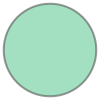

In [13]:
points['points_buffer'][0]

In [14]:
list(points['points_buffer'][0].exterior.coords)[:5]

[(156.6897558575884, -34.6523707513246),
 (156.6416031243104, -35.632542154620204),
 (156.49760866162072, -36.603273971485876),
 (156.2591592149105, -37.55521752386922),
 (155.92855118270128, -38.47920507497549)]

#### Extraction function V1

In [15]:
def extract_mean_from_buffer(raster, geom):
    data_points = pd.Series(geom.exterior.coords)
    values_from_raster = data_points.apply(lambda row: raster.sel(x=row[0], y=row[1], method="nearest").item()).values
    return values_from_raster.mean()

In [16]:
%%memit
extract_mean_from_buffer(myraster, points['points_buffer'][0])

peak memory: 1469.87 MiB, increment: 0.73 MiB


In [17]:
%%timeit
extract_mean_from_buffer(myraster, points['points_buffer'][0])

37.7 ms ± 675 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
extract_mean_from_buffer(myraster, points['points_buffer'][0])

0.0

#### Extraction function V2

In [19]:
def extract_mean_from_bufferv2(raster, geom):
    data_points = geom.exterior.coords
    values_from_raster = raster.sel(x=[el[0] for el in data_points], y=[el[1] for el in data_points], method="nearest")
    return values_from_raster.mean().item()

In [20]:
%%memit
extract_mean_from_bufferv2(myraster, points['points_buffer'][0])

peak memory: 1470.30 MiB, increment: 0.00 MiB


In [21]:
%%timeit
extract_mean_from_bufferv2(myraster, points['points_buffer'][0])

943 µs ± 6.61 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [22]:
extract_mean_from_bufferv2(myraster, points['points_buffer'][0])

0.10224852071005917

#### Investigation of Extraction function V3

In [12]:
coords = points['points_buffer'][0].exterior.coords
coords[:5]

[(156.6897558575884, -34.6523707513246),
 (156.6416031243104, -35.632542154620204),
 (156.49760866162072, -36.603273971485876),
 (156.2591592149105, -37.55521752386922),
 (155.92855118270128, -38.47920507497549)]

In [24]:
raster_data = myraster.data
raster_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [25]:
raster_data.shape

(22031, 29971)

In [26]:
"{:,}".format(raster_data.shape[0] * raster_data.shape[1])

'660,291,101'

In [27]:
len(coords)

65

In [28]:
myraster.coords

Coordinates:
    band         int64 1
  * x            (x) float64 96.82 96.82 96.82 96.82 ... 159.2 159.3 159.3 159.3
  * y            (y) float64 -9.222 -9.224 -9.226 ... -55.11 -55.12 -55.12
    spatial_ref  int64 0

In [29]:
type(myraster.coords)

xarray.core.coordinates.DataArrayCoordinates

In [30]:
raster_coords = myraster.coords

In [31]:
from scipy.spatial.distance import cdist

In [32]:
cdist(coords, myraster.coords)

ValueError: XB must be a 2-dimensional array.

In [34]:
%%memit
o = myraster.coords.to_index()

peak memory: 14106.67 MiB, increment: 12594.18 MiB


In [35]:
type(o)

pandas.core.indexes.multi.MultiIndex

In [ ]:
%%time
%%memit
cdist(coords, o)

In [ ]:
o.memory_usage(deep=True) / 1024**2

In [ ]:
o[:5]